## Amazon Business Research Analyst Hiring Challenge

- This is part of hiring process for Amazon Business Analyst. The data provided here has two target variable - BiasInfluentialFactor and FitmentPercent. The prediction should be bias free as per requirement.


In [1]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBClassifier,XGBRegressor

from sklearn.metrics import roc_auc_score,classification_report,accuracy_score,r2_score,mean_squared_error,f1_score

import warnings
warnings.filterwarnings(action='ignore')
#display all columns
pd.pandas.set_option('display.max_columns',None) 

In [2]:
df_train = pd.read_csv('Train.csv') # load train dataset
df_train.head(3)

,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,11041,John,English,35,Male,JR85289,B.Tech,Electrical,Tier 1,7,12,2009,21,26,Married,5,SSE,Enterprise,Design,20,YearsOfExperince,95.40
1,15079,William,English,26,Male,JR87525,B.Tech,Artificial Intelligence,Tier 3,7,3,2018,15,19,Married,5,BA,MidSized,Engineering,6,NaN,67.09
2,18638,James,English,36,Female,JR87525,PhD,Computer Science,Tier 1,6,6,2015,15,24,Single,5,SDE,MidSized,Engineering,19,Gender,91.26


In [3]:
df_test = pd.read_csv('Test.csv') #load test set
df_test.head(3)

,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
0,5664,Theo,Native,35,Male,JR85289,PhD,Information Technology,Tier 2,5,5,2016,27,34,Single,4,SDE,Enterprise,Finance,18
1,23568,Vernie,English,35,Male,JR85289,B.Tech,Information Technology,Tier 3,9,12,2009,29,33,Married,4,EM,Enterprise,Engineering,8
2,21490,Wendell,English,28,Male,JR87525,M.Tech,Artificial Intelligence,Tier 2,9,2,2019,18,25,Married,3,SDE,Startup,Engineering,18


In [4]:
#dataset shape
print('Train data shape',df_train.shape) 
print('Test data shape',df_test.shape)

Train data shape (13645, 22)
Test data shape (8745, 20)


As seen in the train data has 22 columns and the test set has only two. Seemingly we have to target variable. I have done- 
Regression for prediction of FitmentPercent first, then attemp to predict BiasInfluentialFactor by using a classifier.

## EDA

In [5]:
#function to check null values

def null_find(data):
    temp = 0
    for col in data.columns:
        if data[col].isnull().sum()>0:
            temp +=1
            print (col,'in data have total null ', data[col].isnull().sum(),'=>',
                   round(data[col].isnull().sum()*100/len(data),2),'%')
    if temp==0:
        print('The dataset has no NULL')

In [6]:
print('Train data has NULL -- ')
null_find(df_train)

Train data has NULL -- 
BiasInfluentialFactor in data have total null  3336 => 24.45 %


In [7]:
print('Test data has NULL -- ')
null_find(df_test)

Test data has NULL -- 
The dataset has no NULL


In [8]:
#Functions for analyse the columns

#find categorical columns 

def cat_columns(data):
    cat_columns_var = [col for col in data.columns if data[col].dtype =='O']
    return cat_columns_var

#find Numerical columns 

def numerical_columns(data):
    numerical_columns = [col for col in data.columns if data[col].dtype !='O']
    return numerical_columns

#find unique value columns

def unique_val_columns(data):
    uniq = []
    for col in data.columns:
        if data[col].nunique() == len(data):
            uniq.append(col)
    return uniq

In [9]:
print('Categorical columns in Train data',cat_columns(df_train))
print('\nNumerical columns in Train data',numerical_columns(df_train))
print('\nUnique value columns in Train data', unique_val_columns(df_train))

Categorical columns in Train data ['EmpName', 'LanguageOfCommunication', 'Gender', 'JobProfileIDApplyingFor', 'HighestDegree', 'DegreeBranch', 'GraduatingInstitute', 'MartialStatus', 'CurrentDesignation', 'CurrentCompanyType', 'DepartmentInCompany', 'BiasInfluentialFactor']

Numerical columns in Train data ['EmpID', 'Age', 'LatestDegreeCGPA', 'YearsOfExperince', 'GraduationYear', 'CurrentCTC', 'ExpectedCTC', 'EmpScore', 'TotalLeavesTaken', 'FitmentPercent']

Unique value columns in Train data ['EmpID']


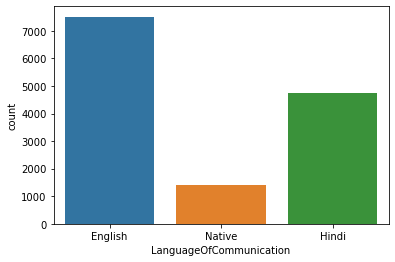

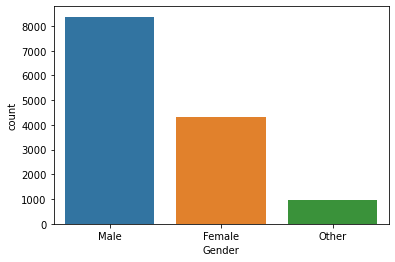

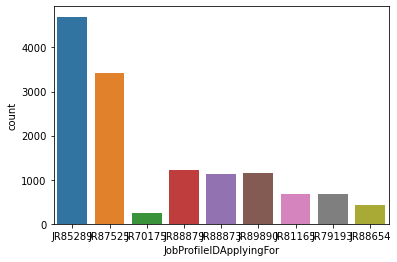

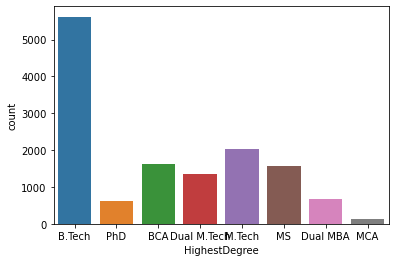

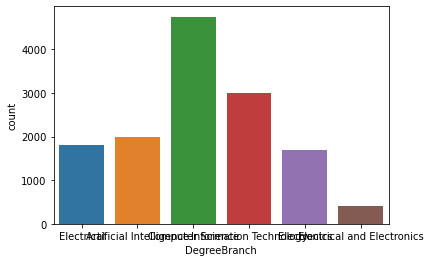

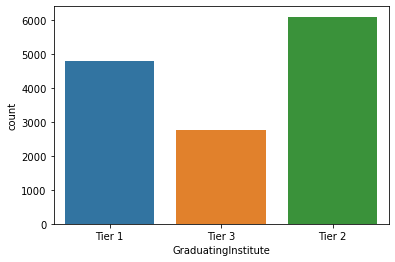

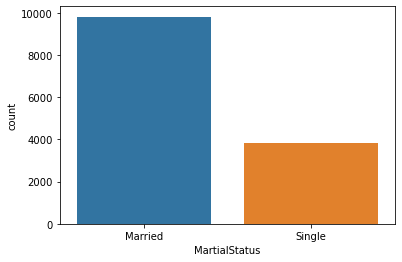

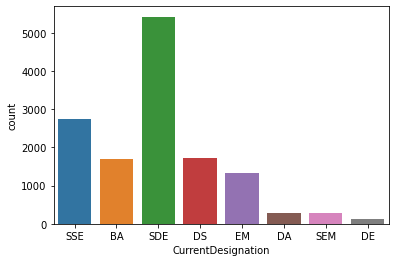

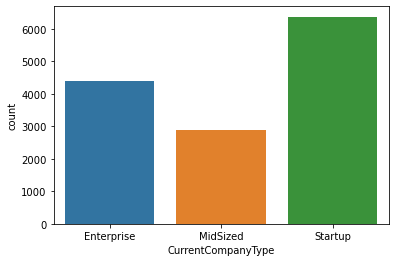

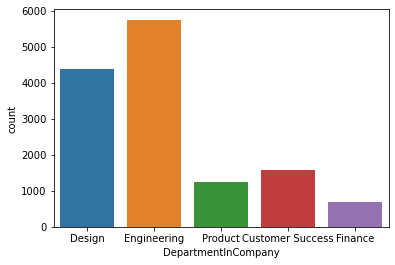

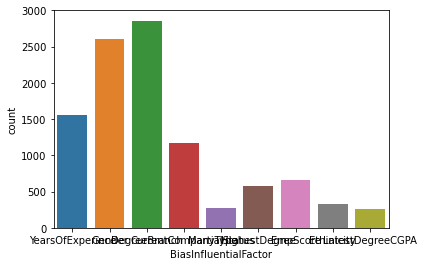

In [10]:
#see the frequency in Categorical columns
for col in cat_columns(df_train):
    if col != 'EmpName':
        sns.countplot(df_train[col])
        plt.show()

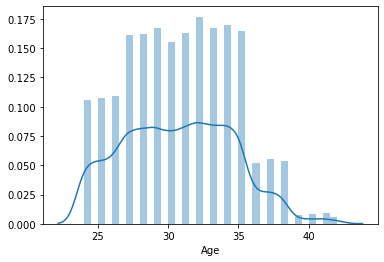

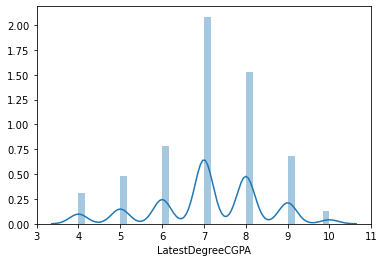

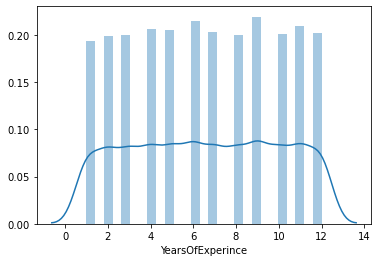

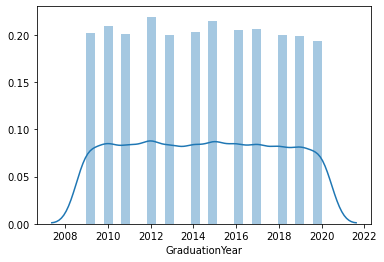

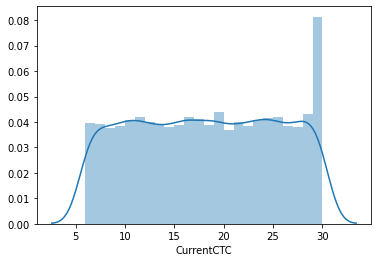

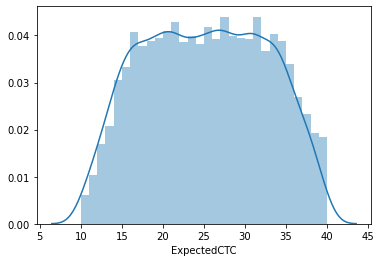

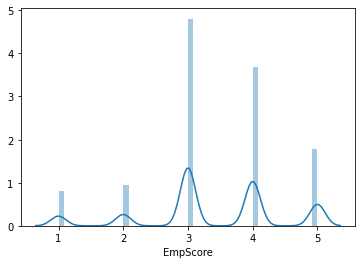

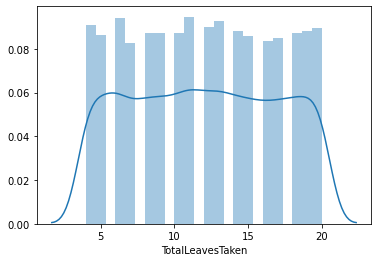

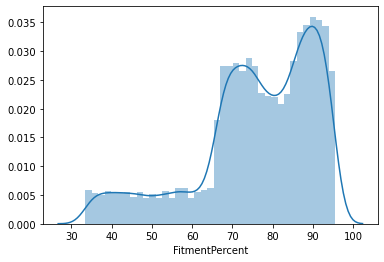

In [11]:
#see the distribution of numerical columns
for col in numerical_columns(df_train):
    if col != 'EmpID':
        sns.distplot(df_train[col])
        plt.show()

### Observation 

- The categorical columns may be transferred to dummy variables
- Target variable BiasInfluentialFactor has few NULLs which can be replaced with some string
- EmpID,EmpName has high cardinality and must be dropped

## Feature Engineering

In [12]:
#storing ID of test data. It'll be needed for final prediction submission file creation

test_data_id = df_test['EmpID']

In [13]:
#drop the columns as these are unique field and high cardinality

df_test.drop(['EmpID','EmpName'],axis=1,inplace=True)
df_train.drop(['EmpID','EmpName'],axis=1,inplace=True)

In [14]:
#target field's frequency 

df_train['BiasInfluentialFactor'].value_counts()

DegreeBranch          2858
Gender                2605
YearsOfExperince      1561
CurrentCompanyType    1174
EmpScore               659
HighestDegree          582
Ethinicity             328
MartialStatus          280
LatestDegreeCGPA       262
Name: BiasInfluentialFactor, dtype: int64

In [15]:
#function for categorical variable to dummy creation

def categorical_variable_dummy(data):
     cat_col = [col for col in data.columns if data[col].dtype == 'O' and col!= 'BiasInfluentialFactor']
     data = pd.get_dummies(data,columns=cat_col)  
     return data

In [16]:
#call function for dummy conversion

df_train = categorical_variable_dummy(df_train)
df_test = categorical_variable_dummy(df_test)

# df_train.head()

## ML Model

We have to predict two fields - FitmentPercent,BiasInfluentialFactor. FitmentPercent prediction needs regression analysis and BiasInfluentialFactor needs classification analysis.

### Regression model to predict FitmentPercent

In [17]:
#import necessary library

from functools import partial
from skopt import space
from skopt import gp_minimize
from sklearn import model_selection

In [18]:
#split the data into feature and label

X=df_train.drop(['FitmentPercent','BiasInfluentialFactor'],axis=1)
y=df_train['FitmentPercent']

In [19]:
#optimizer to find best fit parameters (also include cross validation)

def optimize(params,param_names,x,y):
    params = dict(zip(param_names,params))
    model = XGBRegressor(**params)
    kf = model_selection.KFold(n_splits=3)
    accuracies = []
    for idx in kf.split(X=x,y=y):
        train_idx, test_idx = idx[0],idx[1]
        xtrain = x.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        
        xtest = x.iloc[test_idx]
        ytest = y.iloc[test_idx]
        
        model.fit(xtrain,ytrain)
        preds = model.predict(xtest)
        fold_acc = r2_score(ytest,preds)
        accuracies.append(fold_acc)
    return -1.0 * np.mean(accuracies)

In [26]:
param_space = [
    space.Integer(5,15,name='max_depth'),
    space.Integer(200,700,name='n_estimators'),
    space.Real(0.01,1,prior='uniform',name='learning_rate'),
    space.Real(0.01,2,prior='uniform',name='reg_lambda'),
    space.Real(0.01,1, prior='uniform', name='gamma')
    ]
param_names = [
    'max_depth',
    'n_estimators',
    'learning_rate',
    'reg_lambda',
    'gamma',
    'subsample'
]
optimization_function = partial(
        optimize,
        param_names = param_names,
        x=X,
        y=y
)

In [27]:
result = gp_minimize(optimization_function,
                     dimensions=param_space,
                    n_calls = 18,
                    n_random_starts=10,
                    verbose=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 37.7756
Function value obtained: -0.4041
Current minimum: -0.4041
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 77.6686
Function value obtained: -0.5594
Current minimum: -0.5594
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 99.5321
Function value obtained: -0.5418
Current minimum: -0.5594
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 16.8214
Function value obtained: -0.5376
Current minimum: -0.5594
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 21.0877
Function value obtained: -0.5289
Current minimum: -0.5594
Iteration No: 6 star

In [28]:
print(dict(zip(param_names,result.x))) #print best parameter set

{'max_depth': 5, 'n_estimators': 563, 'learning_rate': 0.01, 'reg_lambda': 1.6261339469459832, 'gamma': 0.01}


In [29]:
#train model and predict based on parameter of optimization

x_r=XGBRegressor(max_depth= 5, n_estimators=563, learning_rate=0.01, reg_lambda=1.6261339469459832, gamma=0.01) # parameters obtained from optimization
x_r.fit(X, y)
prediction_re = x_r.predict(df_test)

### Classifier to find BiasInfluentialFactor

In [71]:
df_train.fillna('Missing',inplace=True) #blank field filled with "Missing"

In [72]:
df_train['BiasInfluentialFactor'].value_counts() #Target field's frequency count

Missing               3336
DegreeBranch          2858
Gender                2605
YearsOfExperince      1561
CurrentCompanyType    1174
EmpScore               659
HighestDegree          582
Ethinicity             328
MartialStatus          280
LatestDegreeCGPA       262
Name: BiasInfluentialFactor, dtype: int64

In [73]:
#dictionary created for encoding categories

dic_bias = {'Missing':1,'DegreeBranch':2,'Gender':3,'YearsOfExperince':4,'CurrentCompanyType':5,'EmpScore':6,
            'HighestDegree':7,'Ethinicity':8,'MartialStatus':9,'LatestDegreeCGPA':10}

In [74]:
#Target and independent variable

X=df_train.drop(['BiasInfluentialFactor'],axis=1)
y=df_train['BiasInfluentialFactor']

In [75]:
#change the categories to numerical by mapping it with dictionary

y=y.map(dic_bias)
y.head()

0    4
1    1
2    3
3    3
4    2
Name: BiasInfluentialFactor, dtype: int64

In [89]:
#optimization for parameter

def optimize(params,param_names,x,y):
    params = dict(zip(param_names,params))
    model = XGBClassifier(**params)
    kf = model_selection.StratifiedKFold(n_splits=3)
    accuracies = []
    for idx in kf.split(X=x,y=y):
        train_idx, test_idx = idx[0],idx[1]
        xtrain = x.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        
        xtest = x.iloc[test_idx]
        ytest = y.iloc[test_idx]
        
        model.fit(xtrain,ytrain)
        preds = model.predict(xtest)
        fold_acc = f1_score(ytest,preds,average='weighted')
#         fold_acc=accuracy_score(ytest,preds)
        accuracies.append(fold_acc)
    return -1.0 * np.mean(accuracies)

In [90]:
param_space = [
    space.Integer(5,12,name='max_depth'),
    space.Integer(200,600,name='n_estimators'),
    space.Real(0.01,1,prior='uniform',name='learning_rate'),
    space.Real(0.05,3,prior='uniform',name='reg_lambda')
    ]
param_names = [
    'max_depth',
    'n_estimators',
    'learning_rate',
    'reg_lambda'
]
optimization_function = partial(
        optimize,
        param_names = param_names,
        x=X,
        y=y
)

In [91]:
result = gp_minimize(optimization_function,
                     dimensions=param_space,
                    n_calls = 18,
                    n_random_starts=10,
                    verbose=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 91.6494
Function value obtained: -0.9659
Current minimum: -0.9659
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 192.8565
Function value obtained: -0.9662
Current minimum: -0.9662
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 95.8813
Function value obtained: -0.9657
Current minimum: -0.9662
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 106.1729
Function value obtained: -0.9656
Current minimum: -0.9662
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 190.8110
Function value obtained: -0.9664
Current minimum: -0.9664
Iteration No: 6 s

In [92]:
print(dict(zip(param_names,result.x))) #best parameter set

{'max_depth': 6, 'n_estimators': 567, 'learning_rate': 0.7642009214647547, 'reg_lambda': 2.9052506373154645}


In [104]:
#Test field doesn't have FitmentPercent column so I have added prediction from regression to test set

df_test['FitmentPercent'] = prediction_re
temp_fit = X['FitmentPercent']
X.drop('FitmentPercent',axis=1,inplace=True)
X['FitmentPercent'] = temp_fit
X.head()

,Age,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,EmpScore,TotalLeavesTaken,LanguageOfCommunication_English,LanguageOfCommunication_Hindi,LanguageOfCommunication_Native,Gender_Female,Gender_Male,Gender_Other,JobProfileIDApplyingFor_JR70175,JobProfileIDApplyingFor_JR79193,JobProfileIDApplyingFor_JR81165,JobProfileIDApplyingFor_JR85289,JobProfileIDApplyingFor_JR87525,JobProfileIDApplyingFor_JR88654,JobProfileIDApplyingFor_JR88873,JobProfileIDApplyingFor_JR88879,JobProfileIDApplyingFor_JR89890,HighestDegree_B.Tech,HighestDegree_BCA,HighestDegree_Dual M.Tech,HighestDegree_Dual MBA,HighestDegree_M.Tech,HighestDegree_MCA,HighestDegree_MS,HighestDegree_PhD,DegreeBranch_Artificial Intelligence,DegreeBranch_Computer Science,DegreeBranch_Electrical,DegreeBranch_Electrical and Electronics,DegreeBranch_Electronics,DegreeBranch_Information Technology,GraduatingInstitute_Tier 1,GraduatingInstitute_Tier 2,GraduatingInstitute_Tier 3,MartialStatus_Married,MartialStatus_Single,CurrentDesignation_BA,CurrentDesignation_DA,CurrentDesignation_DE,CurrentDesignation_DS,CurrentDesignation_EM,CurrentDesignation_SDE,CurrentDesignation_SEM,CurrentDesignation_SSE,CurrentCompanyType_Enterprise,CurrentCompanyType_MidSized,CurrentCompanyType_Startup,DepartmentInCompany_Customer Success,DepartmentInCompany_Design,DepartmentInCompany_Engineering,DepartmentInCompany_Finance,DepartmentInCompany_Product,FitmentPercent
0,35,7,12,2009,21,26,5,20,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,95.40
1,26,7,3,2018,15,19,5,6,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,67.09
2,36,6,6,2015,15,24,5,19,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,91.26
3,29,5,6,2015,16,24,5,16,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,72.29
4,25,8,2,2019,24,32,5,10,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,86.34


In [105]:
#classifier get parameter from optimizer

x_r_c=XGBClassifier(max_depth= 6, n_estimators=567, learning_rate=0.7642009214647547, reg_lambda=2.9052506373154645)
x_r_c.fit(X, y)
prediction_re_class = x_r_c.predict(df_test)
prediction_re_class

array([ 2,  2,  9, ...,  2,  1, 10], dtype=int64)

In [115]:
#dataframe created as per submission rule

submission_df=pd.DataFrame({'EmpID':test_data_id,'BiasInfluentialFactor':prediction_re_class,
                            'FitmentPercent':prediction_re})

In [116]:
#number coded target returned as original categorical variable

reverse_dic_bias = {1:'Missing',2:'DegreeBranch',3:'Gender',4:'YearsOfExperince',5:'CurrentCompanyType',6:'EmpScore',
            7:'HighestDegree',8:'Ethinicity',9:'MartialStatus',10:'LatestDegreeCGPA'}
submission_df['BiasInfluentialFactor'] = submission_df['BiasInfluentialFactor'].map(reverse_dic_bias)

In [117]:
#should be replace with np.nan
submission_df['BiasInfluentialFactor'] = np.where(submission_df['BiasInfluentialFactor']=='Missing',np.nan,submission_df['BiasInfluentialFactor'])

In [118]:
#dataframe to submit

submission_df.head(10)

,EmpID,BiasInfluentialFactor,FitmentPercent
0,5664,DegreeBranch,90.040802
1,23568,DegreeBranch,89.628967
2,21490,MartialStatus,80.988335
3,8363,,57.093945
4,6165,Gender,80.323524
5,17679,,55.699467
6,9715,DegreeBranch,81.542114
7,12591,,55.287682
8,6140,,54.794083
9,21018,,55.110466


In [119]:
submission_df.to_csv('Submission.csv',index=None)

In [120]:
submission_df['BiasInfluentialFactor'].value_counts()

                      2183
Gender                1916
DegreeBranch          1880
YearsOfExperince      1070
EmpScore               513
HighestDegree          398
MartialStatus          316
LatestDegreeCGPA       229
CurrentCompanyType     167
Ethinicity              73
Name: BiasInfluentialFactor, dtype: int64

In [122]:
#most important features in classification

imp_feat=pd.Series(x_r_c.feature_importances_,index=X.columns) 
print(imp_feat.sort_values(ascending=False))

Gender_Female                              0.301526
HighestDegree_MS                           0.178799
CurrentCompanyType_Enterprise              0.116996
DegreeBranch_Information Technology        0.111492
DegreeBranch_Computer Science              0.079677
Gender_Male                                0.050007
EmpScore                                   0.024660
YearsOfExperince                           0.022861
FitmentPercent                             0.019470
Gender_Other                               0.018670
CurrentCTC                                 0.014498
LatestDegreeCGPA                           0.007807
MartialStatus_Married                      0.007143
DegreeBranch_Electrical and Electronics    0.006243
CurrentDesignation_DA                      0.003016
DegreeBranch_Electronics                   0.002558
CurrentDesignation_SEM                     0.002550
DegreeBranch_Electrical                    0.002143
DegreeBranch_Artificial Intelligence       0.001893
JobProfileID